In [2]:
%load_ext autoreload
%autoreload 2

#per la riproducibilità
%env CUBLAS_WORKSPACE_CONFIG=":4096:8"

import os
import itertools
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx
from networkx import stochastic_block_model


from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits, new_parameters_linears
from train import Trainer, Dataset
from embedding import Embedding
from config_valid import Config, TrainingMode
import experiments
from experiments import Experiments, experiment_node_embedding, all_seeds
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D_perclass, plot_node_emb_nD_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_graph_emb_3D, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial,plot_onlyloss_ripetizioni_stesso_trial_superimposed)
from plot_model import plot_model
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect


import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats
from sklearn.metrics import log_loss

import pickle 
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()
rootsave = Path("output_plots/")

env: CUBLAS_WORKSPACE_CONFIG=":4096:8"


# SBM con 2 blocchi

#### creo il grafo

In [2]:
[0.3, 0.05][::-1]

[0.05, 0.3]

In [3]:
def make_planted_matrix(a):
    mat = [a, a[::-1]]
    return mat
make_planted_matrix([ 0.3, 0.05,])

[[0.3, 0.05], [0.05, 0.3]]

In [4]:
community_sizes = [100, 100]
# Edge probabilities between each community
community_probs = [[0.3, 0.05], 
                   [0.05, 0.3]]

In [5]:
sbmg = nx.stochastic_block_model(community_sizes, community_probs)

Draw edges
Draw nodes
Plot


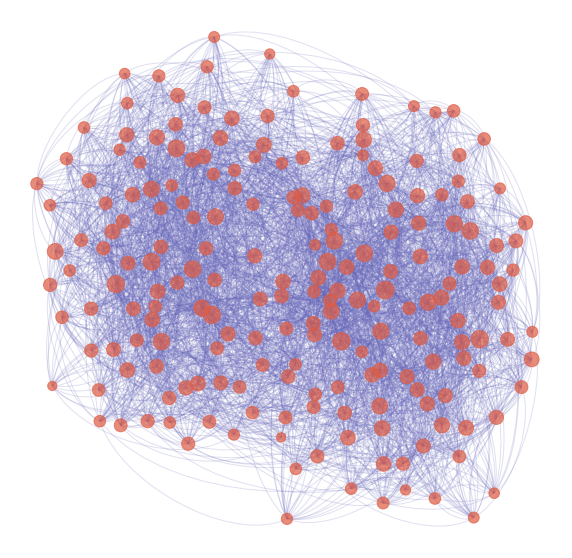

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_grafo(ax, sbmg, iterations=1000)

### Train - dim embedding = 1

In [3]:
config_file = "configurations/classification_sbm.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train(parallel=False)

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


Tempo impiegato: 12.669781923294067


 78%|█████████████████████████████████████████████████████████████████▉                   | 5428/7000 [04:29<01:17, 20.15it/s]

Early stopping!!!
test accuracy finale: 1.0


In [5]:
embedding_class = xp.embedding()

Draw edges
Draw nodes
Plot
Draw edges
Draw nodes
Plot


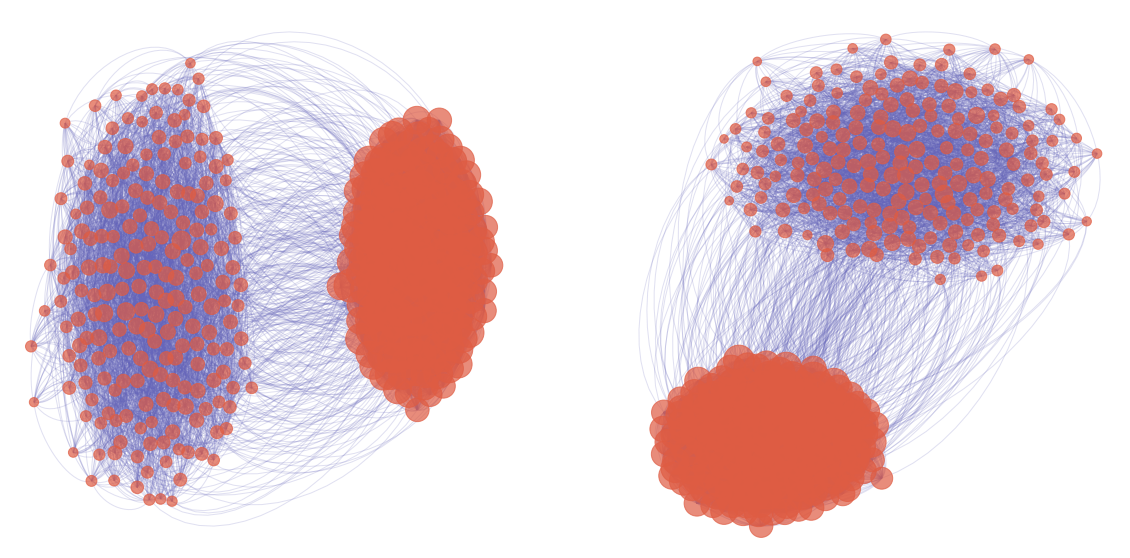

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
plot_grafo(ax1, xp.trainer.gg.dataset.dataset_list[1], iterations=500)
plot_grafo(ax2, xp.trainer.gg.dataset.dataset_list[20], iterations=500)

Draw edges
Draw nodes
Plot
Draw edges
Draw nodes
Plot


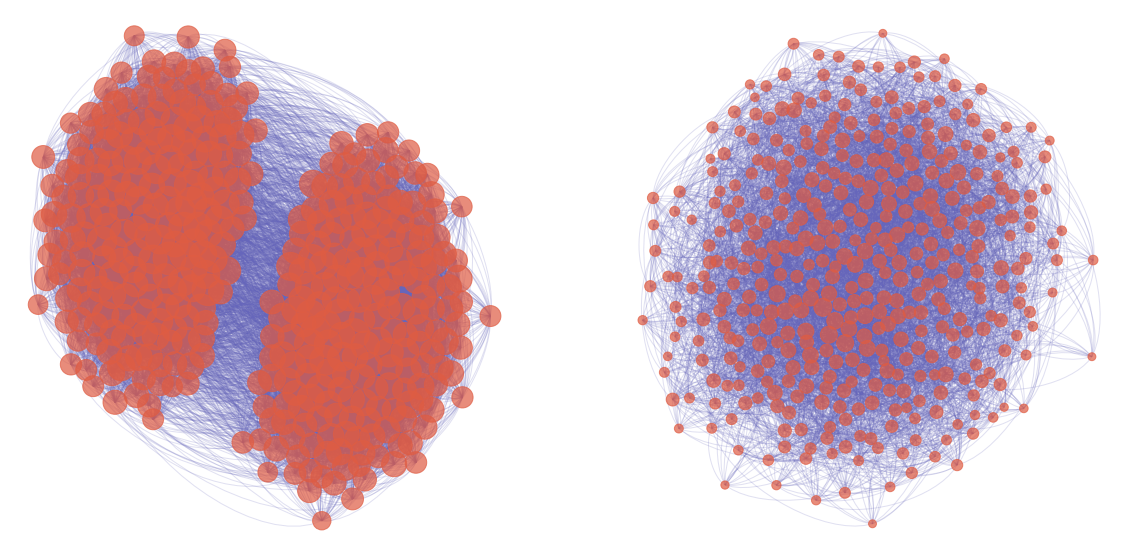

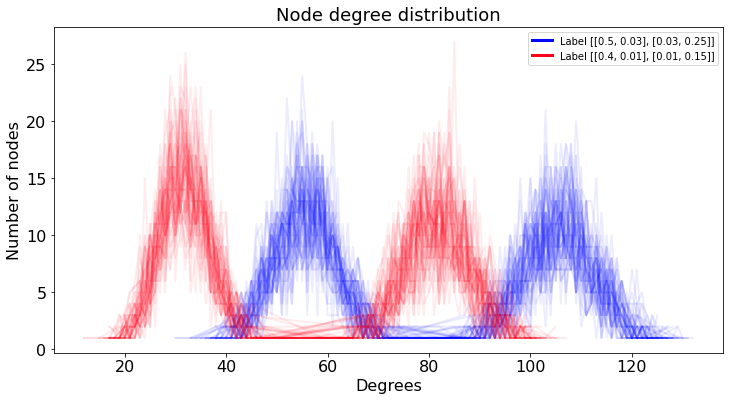

In [5]:
plot_data_degree_sequence(embedding_class.emb_perclass, log=False)

In [33]:
#embedding_class.dataset.scalar_label #emb_pergraph[0].scalar_label

In [32]:
#xp.trainer.dataset.scalar_label

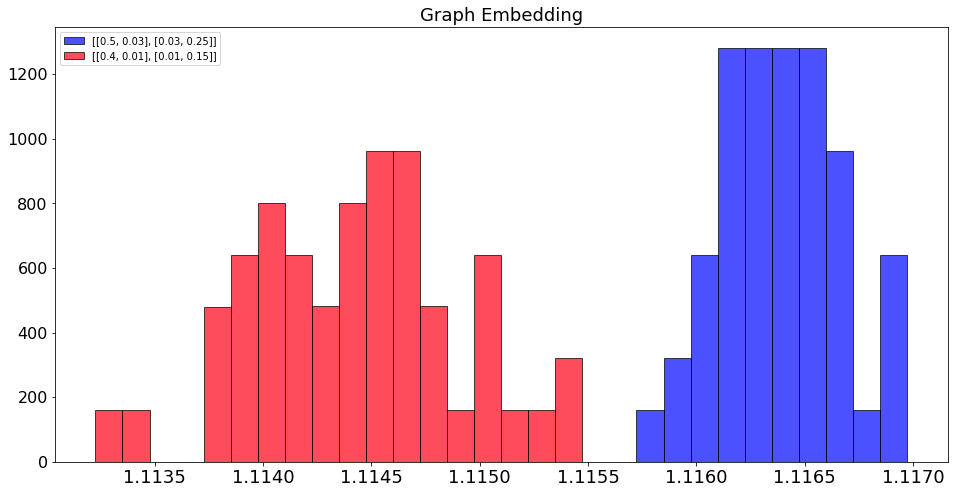

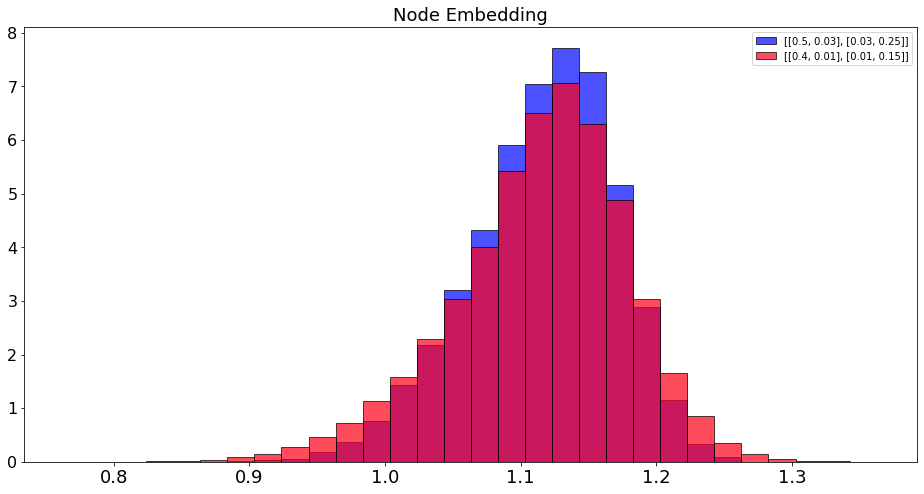

In [9]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
train_mode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, train_mode)

In [16]:
#plot_graph_emb_1D(embedding_class.emb_perclass)

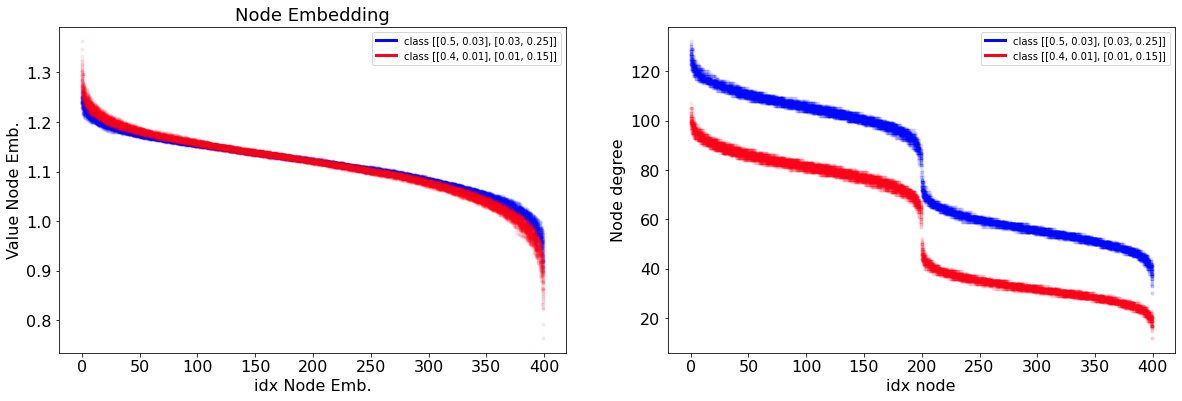

In [7]:
plot_node_emb_1D_perclass(embedding_class.emb_perclass)

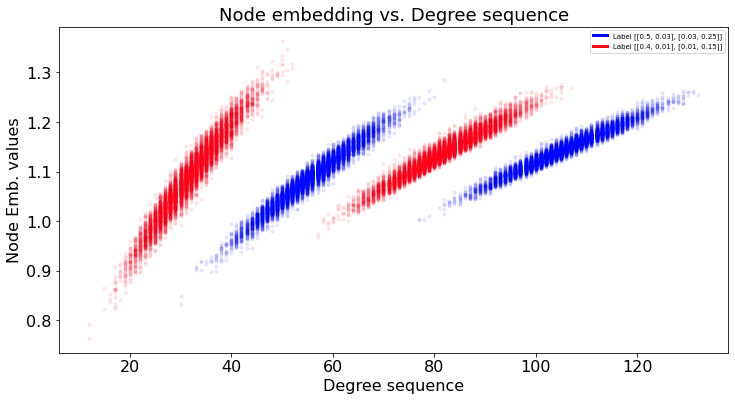

In [8]:
scatter_node_emb(embedding_class.emb_perclass, sequential_colors=False, filename=None)

### senza layer Linear

In [10]:
config_file = "configurations/classification_sbm.yml"
c = Config(config_file)
c.conf['training']['mode'] = 'mode2'    # perché vogloio mantenere dim embedding = 1
c.conf['model']['last_layer_dense'] = False
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train(parallel=False)
embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.11it/s]


Tempo impiegato: 49.40119218826294


100%|█████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [16:15<00:00,  7.17it/s]


test accuracy finale: 0.43333333333333335


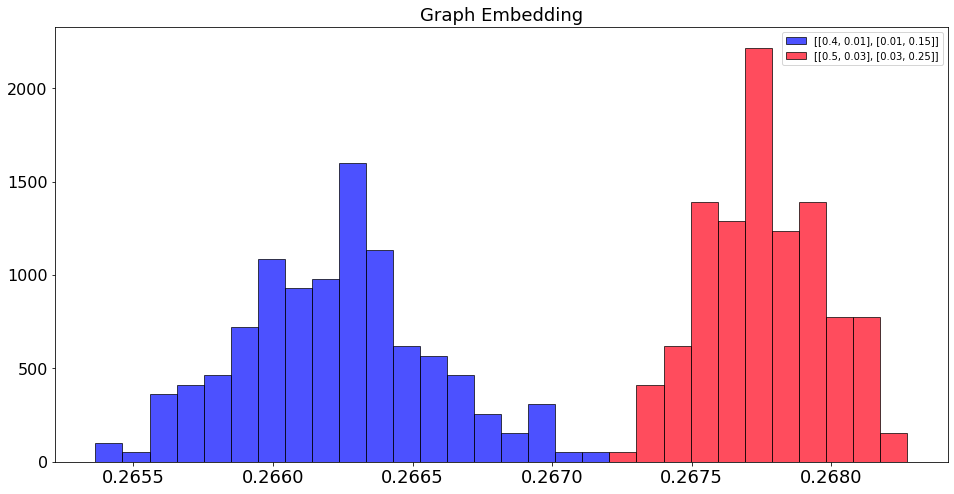

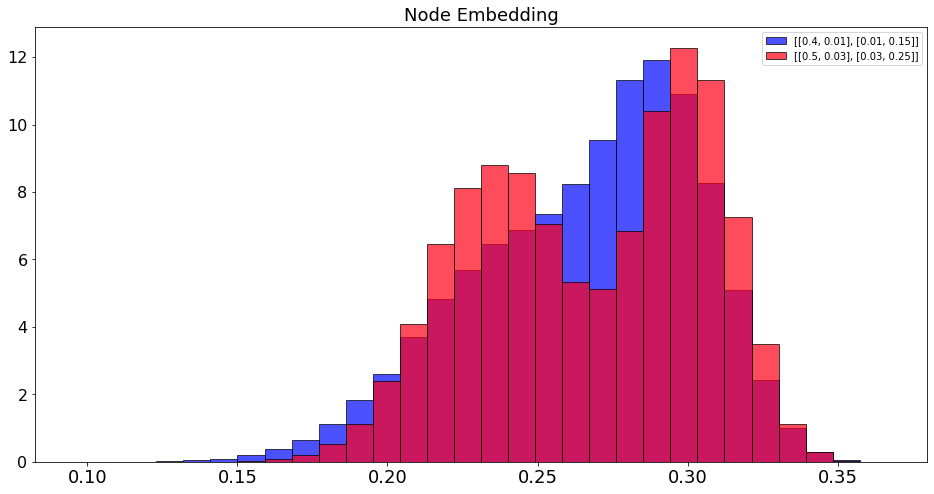

In [11]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
train_mode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, train_mode)

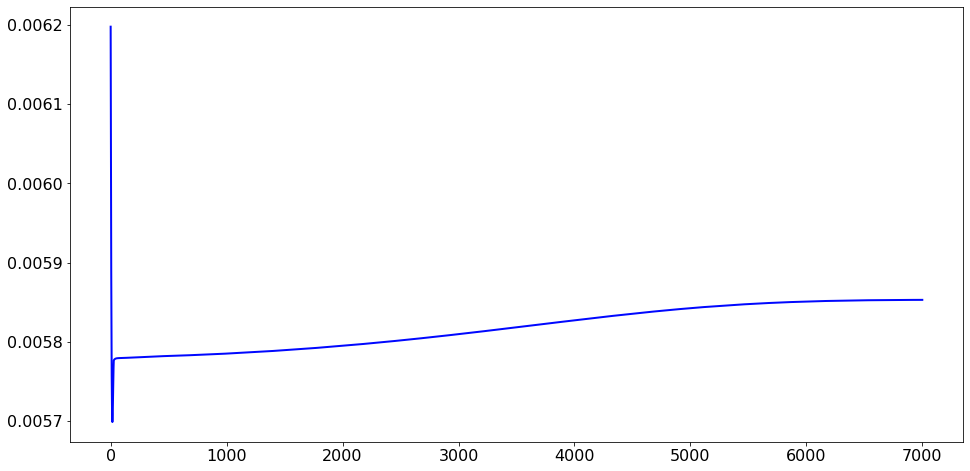

In [14]:
plt.plot(xp.trainer.test_loss_list)

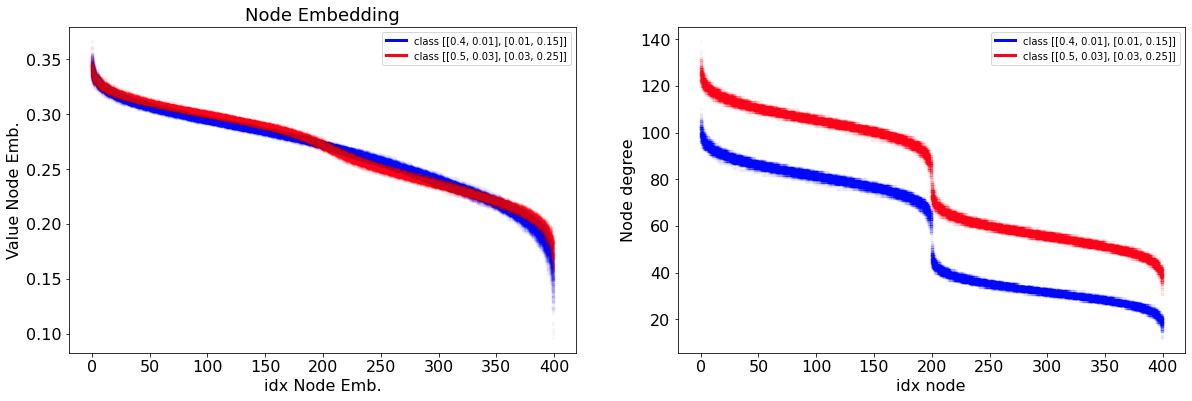

In [15]:
plot_node_emb_1D_perclass(embedding_class.emb_perclass)

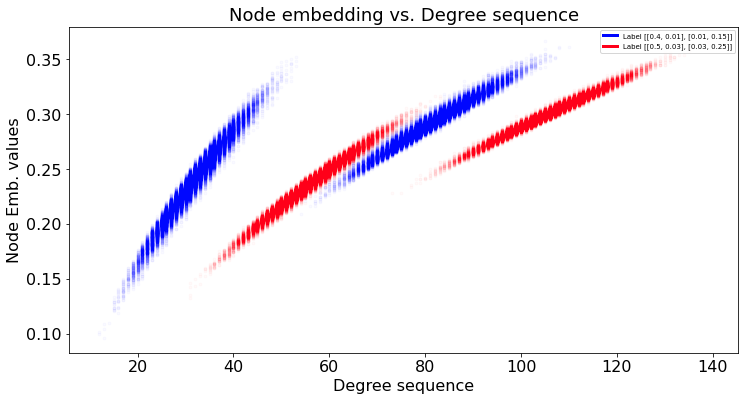

In [16]:
scatter_node_emb(embedding_class.emb_perclass, sequential_colors=False, filename=None)

### Dim embedding = 2 - con Linear

In [17]:
config_file = "configurations/classification_sbm.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train(parallel=False)
embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.25it/s]


Tempo impiegato: 48.61606693267822


 45%|██████████████████████████████████████                                               | 3138/7000 [07:40<09:26,  6.81it/s]


Early stopping!!!
test accuracy finale: 1.0


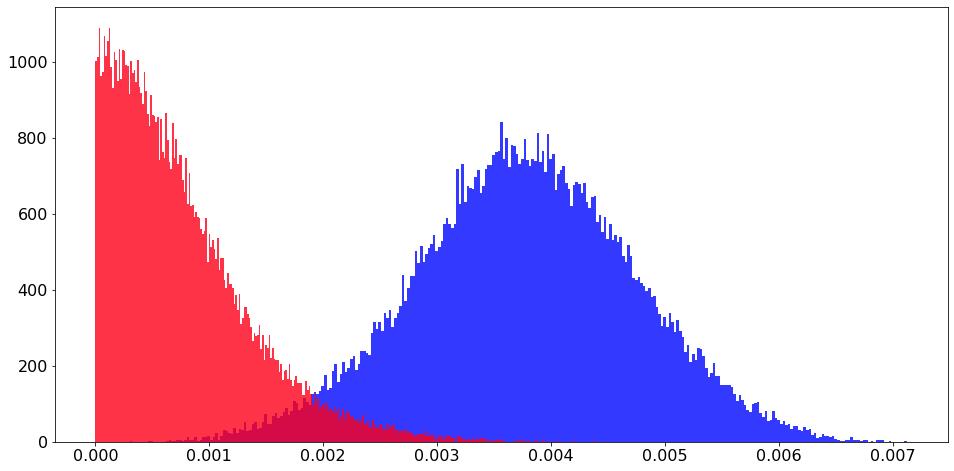

In [18]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
train_mode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, train_mode)

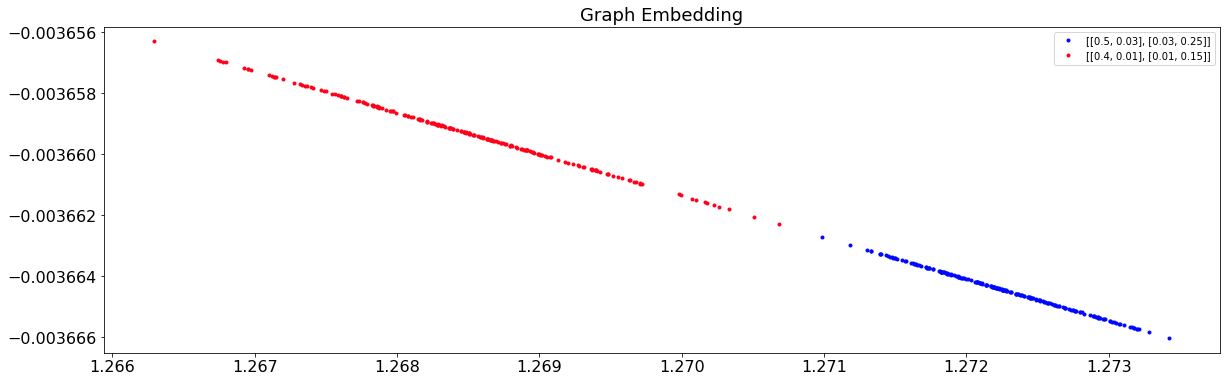

In [19]:
plot_graph_emb_3D(embedding_class.emb_perclass)

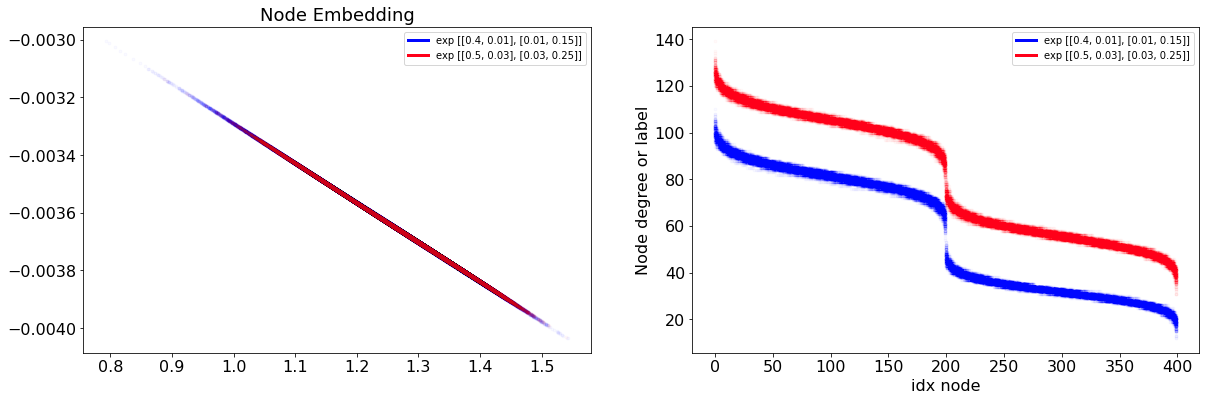

In [20]:
plot_node_emb_nD_perclass(embedding_class.emb_perclass)

### senza layer Linear

In [3]:
config_file = "configurations/classification_sbm.yml"
c = Config(config_file)
c.conf['model']['last_layer_dense'] = False
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train(parallel=False)
embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.36it/s]


Tempo impiegato: 38.72138166427612


100%|█████████████████████████████████████████████████████████████████████████████████| 20000/20000 [1:02:26<00:00,  5.34it/s]


test accuracy finale: 1.0


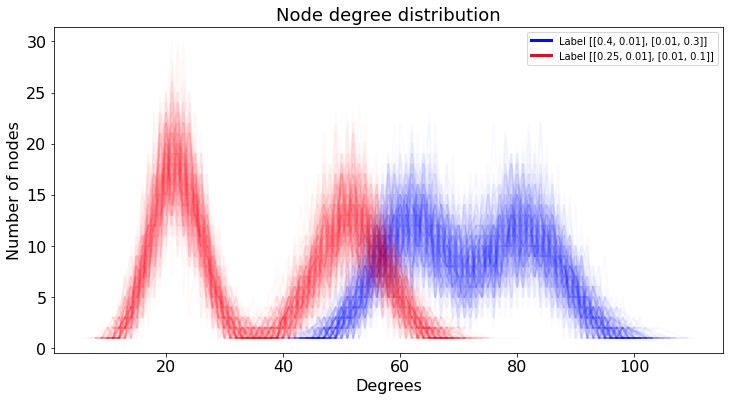

In [7]:
plot_data_degree_sequence(embedding_class.emb_perclass, log=False)

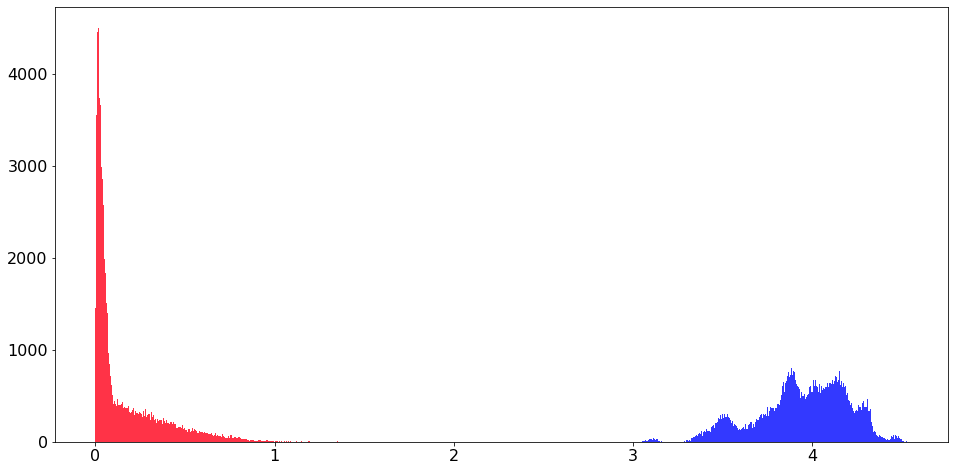

In [4]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
train_mode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, train_mode)

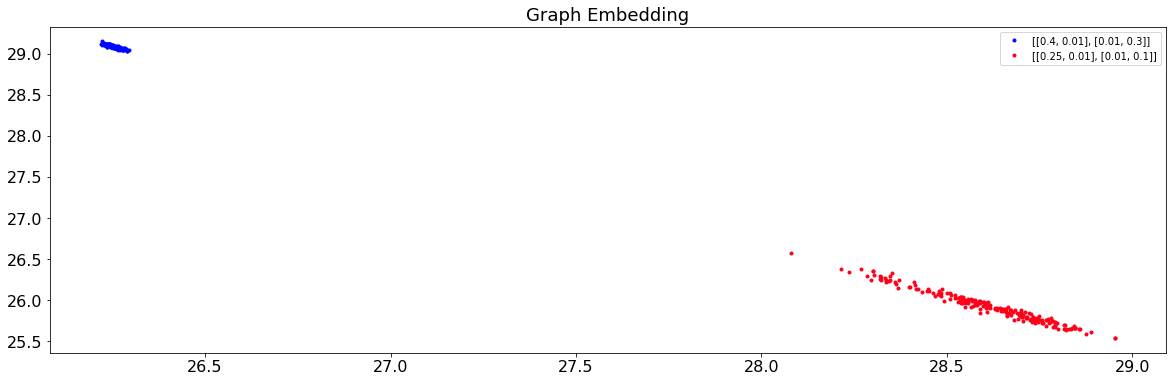

In [5]:
plot_graph_emb_3D(embedding_class.emb_perclass)

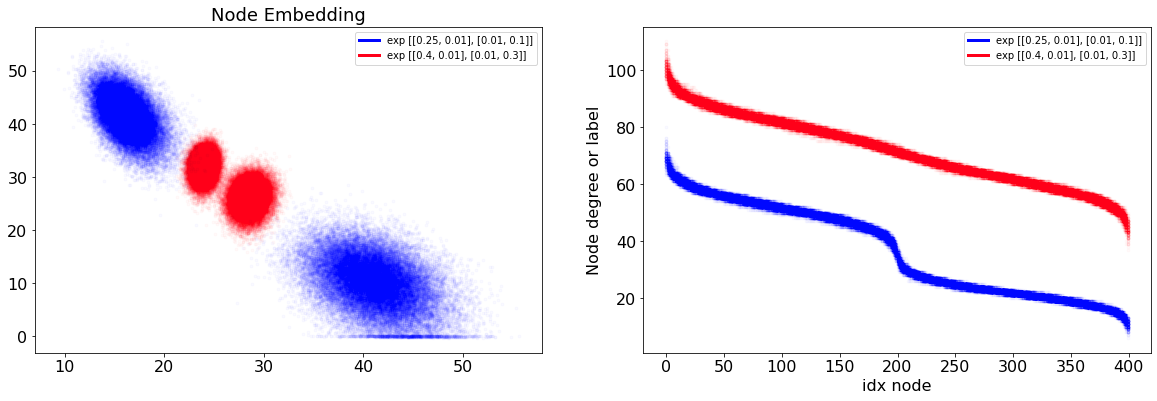

In [6]:
plot_node_emb_nD_perclass(embedding_class.emb_perclass)

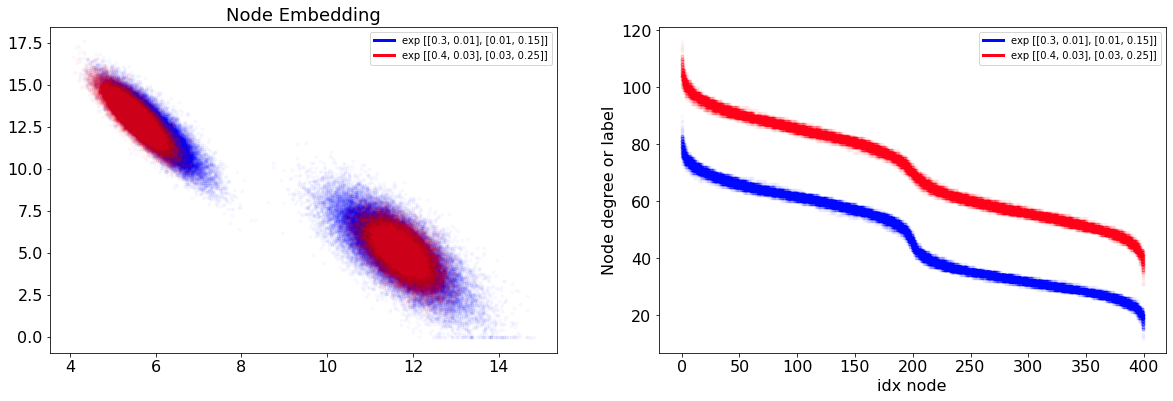

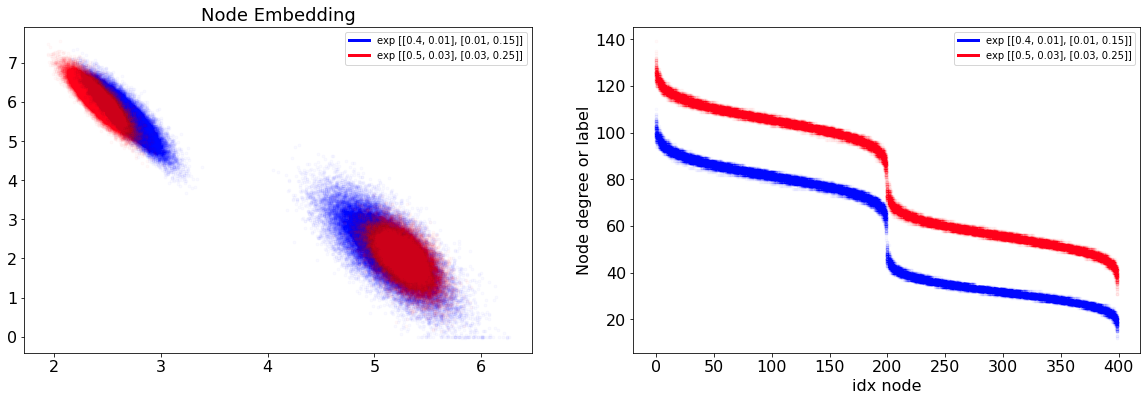

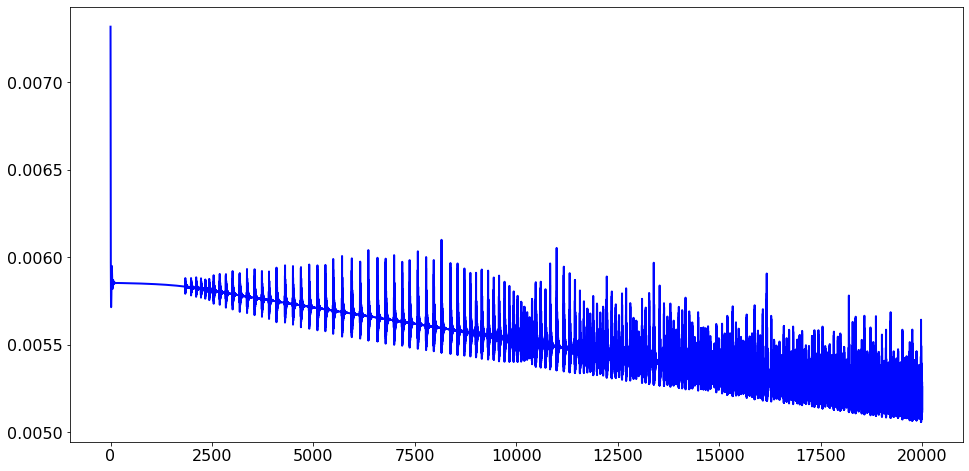

In [3]:
plt.plot(xp.trainer.test_loss_list)